# RANDOM FOREST REGRESSOR.

Random forest algorithm is a supervised machine learning technique that uses decision tree as its base for prediction. It ensembles multiple decision trees together and aggregates/votes values to estimate the values. When training each estimator, it introduces random trees that run parallel and do not interact with each other during tree building. This model can perform both classification and regression but we are going to test the latter. 

By combining multiple models, this algorithm achieves higher prediction accuracy and optimisation by reducing variance across models. Random forest uses bagging technique(ensemble type) where multiple models run independently in parrallel then their values averged to give an outcome. Boosting on the other end learns sequentially and corrects errors at each step to imrove stability of a model. It adapts to the model.  

Random forest regressor learns by building many decision tress, mostly 100's, then finds the average regression of all trees. Original data is brocken into small subsets (tuples) iteratively, in each, an observation is selected through row sampling with replacement method (boostraping). A model is then created and learns from each training sample and then returns an outcome. The model then counts all values and the one having most occurance is assigned to an unknown value X, this is bagging.  Individual decision trees have high varaiance, but when they are combined in parrallel then the resulting variance is greatly reduced since each model is trained perfectly on different  sample data. Accuracy is higher becaused a decision is pegged on multiple models (no dependence on a single model). 

Random Forest is generally more accurate and robust than regression. It is also less prone to overfitting because it emphasises on the element of randomness which means that it is more likely to generalize well to new data. This also ensures that the tree are NOT correlated as much as possible. 

Random forests is designed to handle shortfalls from decision tree, this includes ;

- Decision trees are prone to overfitting because of high variances in single models. With random forests, variance is reduced by running and ensemble of decisions tree models.
- Decision tree model is highly sensitive, minor changes in the original data can give a completly different prediction making them very unstable.  




Like any other machine learning process, the steps are as follows ;

1. Define a problem - predict US election voter turnout for the 2020.
2. Access data in the appropriate format for python language 
3. Study the data to correct anomalies such as missing values that may hinder you from achieving the objective.
4. Create a machine learning model, random forest regressor will be used.
5. Train the model to understand relationship betweem predictor and target variables. 
6. Test your model and evaluate performance. 
7. Refine your model to suite your objectives - get more data, use a different technique, add parameters.
8. Finally interpret the data gained and report as needed. 


We need an algorithm that will predict the voter turnout for the year 2020 election based on independent variables such as previous turnout , income and age all aggregated at county level. 

In [1]:
# Import Required libraries. 
import pandas as pd 
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.feature_selection import SelectKBest, f_regression

# 1. Data Preparation.

In [16]:
# Load data 

path = 'F:/Programs/Secrets of ML/Data/US_Elections.gpkg'

# Read data containing county polygons. 
data = gpd.read_file(path, layer='US_CountyElections_clean')

# State  
states = data.dissolve(by='state_abbr', aggfunc='sum')

# Regions 
regions = data.dissolve(by='region', aggfunc='sum')

# Read cities data 
cities_10 = gpd.read_file(path, layer='US_Cities10')
cities_9 = gpd.read_file(path, layer='US_Cities9')
cities_8 = gpd.read_file(path, layer='US_Cities8')

print(f'County data ------> shape : {data.shape}   ||  Projection : {data.crs} \n Columns : {data.columns } \n----------------\n\
       City 10 data ------> Shape : {cities_10.shape}   ||   Projection : {cities_10.crs} \n \
       City data columns: {cities_10.columns}')


County data ------> shape : (3108, 18)   ||  Projection : EPSG:3857 
 Columns : Index(['county_FIPS', 'name', 'population', 'state_abbr', 'state_fips',
       'state_name', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', 'voter_turnout_2020', '2022_median_age',
       '2022_per_capitalincome', 'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5', 'region', 'geometry'],
      dtype='object') 
----------------
       City 10 data ------> Shape : (10, 7)   ||   Projection : EPSG:3857 
        City data columns: Index(['CLASS', 'STFIPS', 'city_FIPS', 'POP_CLASS', 'POPULATION', 'POP2010',
       'geometry'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_13044\4067427604.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title = "Legend", fontsize="15", loc='lower left') # Legend


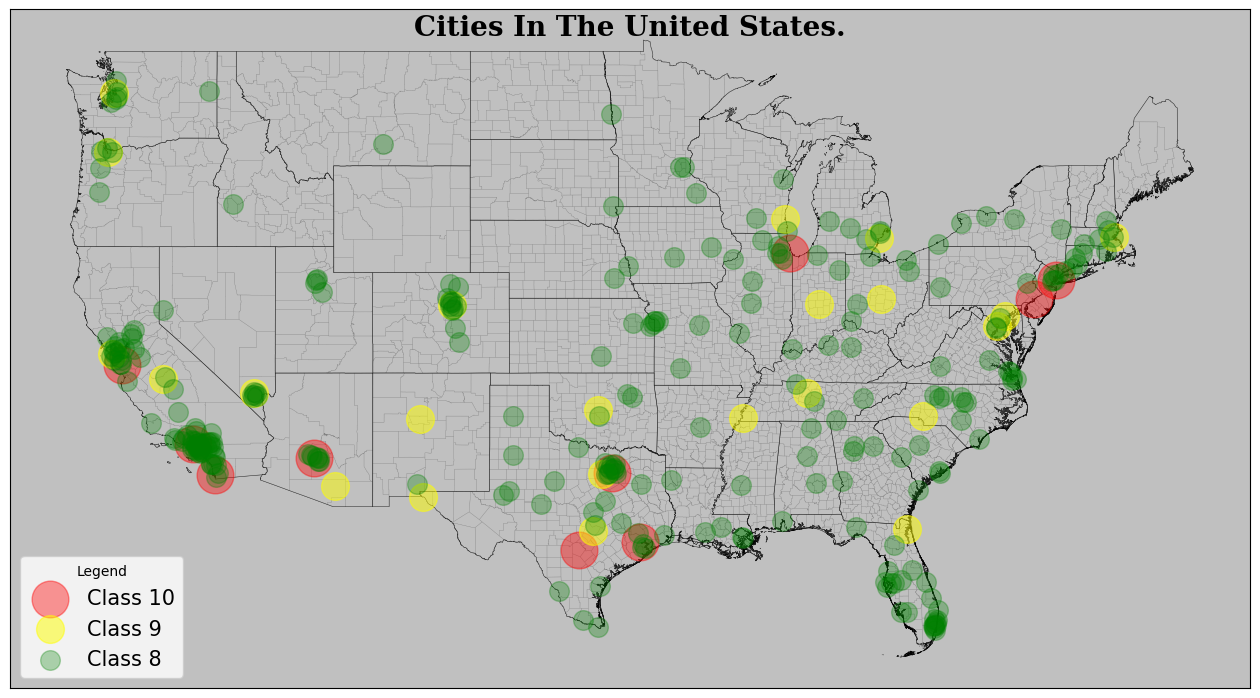

In [3]:
# Plot data 

# Initiate plot
fig, ax = plt.subplots(figsize=(16, 12))

# Add various features 
data.plot(ax=ax, color='#C0C0C0', edgecolor='black', linewidth=0.2, alpha=0.6)
states.plot(ax=ax, color='#C0C0C0', edgecolor='black', linewidth=0.4, alpha=0.6, label='states')
cities_10.plot(ax=ax, marker='o', color='red', markersize = 700, alpha=0.4, label='Class 10')
cities_9.plot(ax=ax, marker='o', color='yellow', markersize=400, alpha=0.5, label='Class 9')
cities_8.plot(ax=ax, marker='o', color='green', markersize=200, alpha=0.3, label='Class 8')

plt.legend(title = "Legend", fontsize="15", loc='lower left') # Legend
plt.title("Cities In The United States.", fontsize=20, fontweight='bold', 
          fontfamily='serif', y=0.95, color='black')  # Title 
                                                     
# get current axes
ax = plt.gca()
ax.get_xaxis().set_visible(False)   #hide x-axis
ax.get_yaxis().set_visible(False)    #hide y-axis 
ax.set_facecolor('#C0C0C0')  # Background colour of plot area
plt.show()


# 2. Feature Engineering. 

Machine learning models are dependent on features used to train them. A terrible feature will have a negative impact resulting to inadequate models. Feature engineering allows data to be refined by creating new features from existing models. This is aimed at simplifying data and transforming models thus improving perfomance and accuracy. 

Our data contains the population for each county polygon, by defining population density within a geographic region, we will asses the changes on the algorithm. 

                Pop density = Popultion / Area

We also intend to add a proximity to city variable, distance variable that describes the urban and rural characteristics of a county. Cities in the US are classified based on population, i.e cities 10 are more populous than cities 8. We need to determine the distance between a county to each class of a city, rural counties are located far while urban ones are closer to cities. Distance will be determined by calculating the ellipsoidal distance from the center of a polygon to the closest city in all classes. A county will have 3 variables representing distances to cities of class 10, 8 and 7.

The geographica designation of a county will also be included in our model. The US has 10 regions dividing the lager continental area to smaller component that can be used to study various phenomenos. These sub regions can distinguish culture, location, natural features and even climate. This data is represented in categorical format and must be converted to an appropriate format that is readable by a machine learning algorithms.  

## 2.1 Population Density Feature.

Using geopandas modile the area for each county is calculated then used to find population density. 

<Axes: >

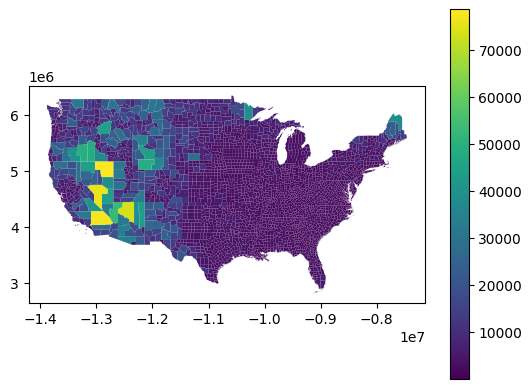

In [13]:
# Add area column in km square, crs must be in projected coordinate system
sample = data.copy()
data['area_sq_KM'] = data['geometry'].area/ 10**6

data.plot(column='area_sq_KM', legend=True)

## 2.2 Proximity Analysis.

Create a function that calculates the distance from the center of the polgon to the closest city. All geopandas operaiona are planar, meaning the do not have a third dimension and use projected coordinate system that uses meters as units. Geographic system results in errors since it uses a cartesian coordinate that is suited for angular distances. 

In [17]:
# Lets design a function that takes in a city layer, polygon and class then generates the distance between them.
# Counties that intersect with cities have distance 0

def closest_city(counties, cities, size):
    
    # ------- Centroid -----------
    # Find the centroid of each polygon, we will find the closest city to the center of polygon  
    counties['centroid_county'] = counties.centroid
    # Set center as link, join will use this column (instead of polygon) to find the closest city  
    counties = counties.set_geometry('centroid_county')


    #------- Nearest Join --------
    # Find the closest city to each polygon, include distance column 
    # Output is an union of both layers with and added distance column.
    # N\B - the geometry column of the second layer(right), in this case cities is not retuned
    cities_w_counties = gpd.sjoin_nearest(counties, cities, distance_col="distances", how='inner')

    # Divide distances by 1000 to get km units
    cities_w_counties.distances = cities_w_counties.distances / 1000


    # --------------      Merge operation     -------------------------------
    # Extract the geometry of the point layer with an left join with points layer
    merged = pd.merge(cities_w_counties, cities, how="left", on=["city_FIPS", "city_FIPS"])


    # Filter columns, remove all columns from point layer except geometry and distance of point
    # Geometry of polygon layer is removed to prevent complications during merging later 
    merged = merged[['county_FIPS', 'city_FIPS', 'geometry_y', 'distances']] 
    

    # Rename columns
    if size == 10 :
        merged.rename(columns={'distances':'distances_10', 
                               'geometry_y':'geometry_point',
                               'city_FIPS':'city10_FIPS'}, inplace=True)
    elif size == 9:
        merged.rename(columns={'distances':'distances_9',
                               'city_FIPS':'city9_FIPS'}, inplace=True)
    elif size == 8:
        merged.rename(columns={'distances':'distances_8',
                               'city_FIPS':'city8_FIPS'}, inplace=True)
    elif size == 7:
        merged.rename(columns={'distances':'distances_7',
                               'city_FIPS':'city7_FIPS'}, inplace=True)
    else :
        merged.rename(columns={'distances':'distances_6',
                               'city_FIPS':'city6_FIPS'}, inplace=True)
        

    return merged


# Call function passing county layer, city points, and city class, then assign values to variables 
data_merged_10 = closest_city(data, cities_10, 10)
data_merged_9 = closest_city(data, cities_9, 9)
data_merged_8 = closest_city(data, cities_8, 8)


In [18]:
# Merge data to original dataframe 
data2 = data.merge(data_merged_10, on='county_FIPS', how='inner')\
                .merge(data_merged_9, on='county_FIPS', how='inner')\
                .merge(data_merged_8, on='county_FIPS', how='inner')

# Remove duplicated columns 
data2 = data2.drop(['geometry_y_x', 'geometry_y_y'], axis=1)

print(f'Columns : {data2.columns} \n ----------- \n Size : {data2.shape} \n---------------- \n \
      Sample : {data2.head(2)}')

Columns : Index(['county_FIPS', 'name', 'population', 'state_abbr', 'state_fips',
       'state_name', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', 'voter_turnout_2020', '2022_median_age',
       '2022_per_capitalincome', 'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5', 'region', 'geometry', 'centroid_county', 'city10_FIPS',
       'geometry_point', 'distances_10', 'city9_FIPS', 'distances_9',
       'city8_FIPS', 'distances_8'],
      dtype='object') 
 ----------- 
 Size : (3108, 26) 
---------------- 
       Sample :   county_FIPS            name  population state_abbr state_fips state_name  \
0       01001  Autauga County       58805         AL         01    Alabama   
1       01003  Baldwin County      231767         AL         01    Alabama   

   voter_turnout_2008  voter_turnout_2012  voter_turnout_2016  \
0            0.621968            0.590258           

In [ ]:
# 

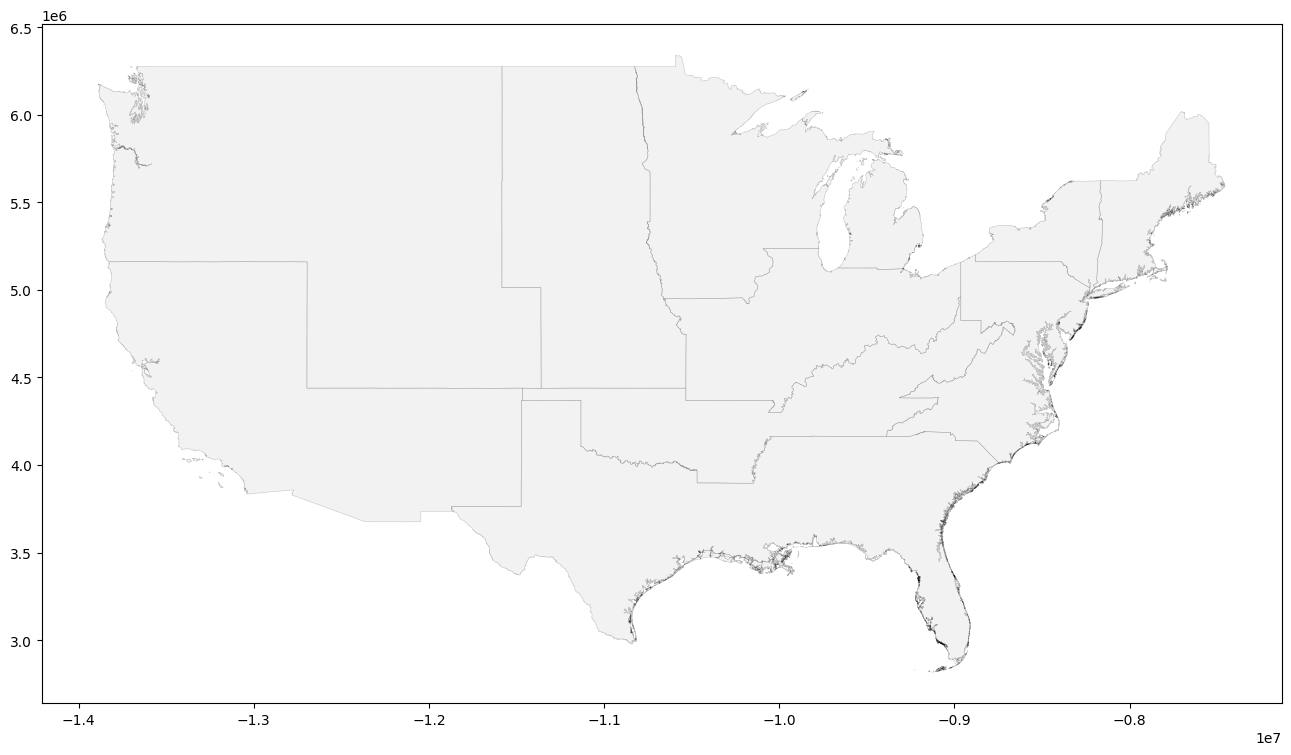

In [9]:
# Initiate plot
fig, ax = plt.subplots(figsize=(16, 12))

regions.plot(ax=ax, color='#C0C0C0', edgecolor='black', linewidth=0.4, alpha=0.2, label='states')

plt.show()

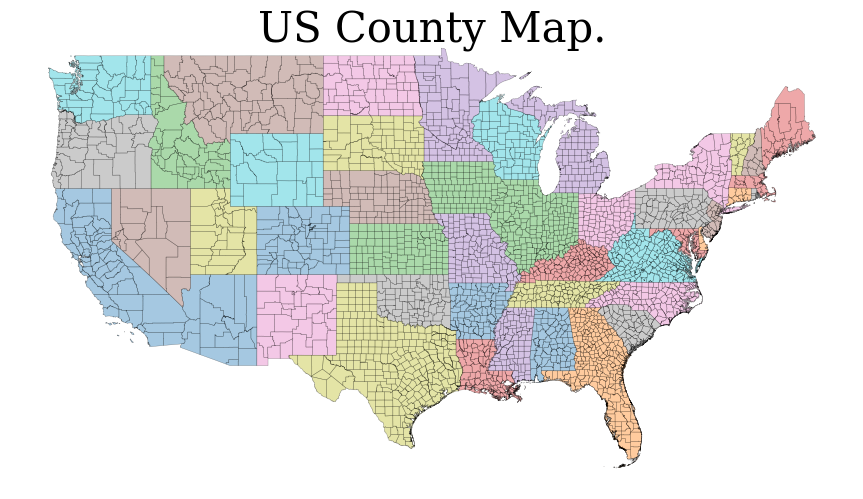

In [24]:
# Plot data  

fig, ax = plt.subplots(figsize=(17, 6))

data.plot(column='state_name',        # Colour based on state 
                #categorical=True,
                legend=False,
                ax=ax,
                edgecolor='black', linewidth=0.3, alpha=0.4)

# Adjust legend location
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((1.15,0.5))

# Remove Axis 
ax.set_axis_off()

# Title 
ax.set_title("US County Map.", fontweight="medium", size=30, y=0.95, color='black', fontfamily='serif')

plt.show()

In [26]:
# Find the best 20 features to be used in prediction 

# Select only numerical variables 
numerical_features = data.select_dtypes(include='number')

# Define predictor variables 
X = numerical_features.drop(columns=['voter_turnout_2020'])

# Variable to be predicted 
y = numerical_features['voter_turnout_2020']


# Define and fit model 
k_best = SelectKBest(score_func=f_regression, k=20)
fit = k_best.fit(X, y)

# Print feature names
X.columns[fit.get_support(indices=True)].to_list()

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


['voter_turnout_2008',
 'voter_turnout_2012',
 'voter_turnout_2016',
 'voter_turnout_dem_2020',
 'voter_turnout_gop_2008',
 'voter_turnout_gop_2012',
 'voter_turnout_gop_2016',
 'voter_turnout_gop_2020',
 '2022_median_age',
 '2022_per_capitalincome',
 'financial_',
 'perc_2022_age_25+_no_diploma/highschool',
 'perc_2022_income_below_povertyline',
 'perc_2022_age_25+_with_bachelors_degree',
 '2022_avg_disposable_income',
 'miscellane',
 'educatio_2',
 '2022_avg_credit_card_debt',
 '2022_average_houshold_income',
 'lifemode_5']

# Model 1. 


In [31]:
# Subset data picking best variables from the SelectKBest model and adding target feature
data2 = data[['voter_turnout_2008', 'voter_turnout_2012', 'voter_turnout_2016', 'voter_turnout_2020', '2022_median_age',
              '2022_per_capitalincome',  'perc_2022_age_25+_no_diploma/highschool',  '2022_avg_disposable_income',
              'perc_2022_income_below_povertyline', 'perc_2022_age_25+_with_bachelors_degree',  'lifemode_5', 'geometry']]

data2

,voter_turnout_2008,voter_turnout_2012,voter_turnout_2016,voter_turnout_2020,2022_median_age,2022_per_capitalincome,perc_2022_age_25+_no_diploma/highschool,2022_avg_disposable_income,perc_2022_income_below_povertyline,perc_2022_age_25+_with_bachelors_degree,lifemode_5,geometry
0,0.621968,0.590258,0.604600,0.632502,39.1,32233.0,7.53,66149.0,12.99,17.39,7.16,"MULTIPOLYGON (((-9619464.071 3856528.446, -961..."
1,0.622114,0.592132,0.598103,0.627867,43.3,37891.0,5.77,70900.0,10.42,22.58,11.50,"MULTIPOLYGON (((-9742872.755 3543445.886, -974..."
2,0.556459,0.558418,0.523712,0.535949,40.4,22826.0,16.10,46539.0,24.61,8.60,5.37,"MULTIPOLYGON (((-9490858.667 3782744.572, -949..."
3,0.500521,0.481143,0.499095,0.542704,39.8,25152.0,12.53,54495.0,18.79,7.17,0.00,"MULTIPOLYGON (((-9692113.620 3928122.783, -969..."
4,0.597636,0.570011,0.600305,0.632245,41.3,28176.0,9.49,58344.0,15.30,9.56,10.06,"MULTIPOLYGON (((-9623906.164 4063675.340, -962..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3103,0.570610,0.548183,0.556711,0.555581,35.5,37688.0,3.64,77322.0,10.68,17.51,9.39,"MULTIPOLYGON (((-12229789.690 5201141.473, -12..."
3104,0.818477,0.711387,0.754752,0.855977,39.1,58009.0,1.93,104190.0,5.79,42.90,2.57,"MULTIPOLYGON (((-12319490.602 5569137.940, -12..."
3105,0.598294,0.590730,0.603922,0.665892,35.9,32885.0,3.11,70602.0,8.09,13.19,24.21,"MULTIPOLYGON (((-12352602.028 5098190.980, -12..."
3106,0.679934,0.654063,0.621679,0.672560,43.2,30448.0,4.82,58243.0,8.46,18.50,47.32,"MULTIPOLYGON (((-12083425.933 5491551.202, -12..."


In [30]:
# Check missing values 

print(data2.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   voter_turnout_2008                       3108 non-null   float64
 1   voter_turnout_2012                       3108 non-null   float64
 2   voter_turnout_2016                       3108 non-null   float64
 3   voter_turnout_2020                       3108 non-null   float64
 4   2022_median_age                          3108 non-null   float64
 5   2022_per_capitalincome                   3108 non-null   float64
 6   perc_2022_age_25+_no_diploma/highschool  3108 non-null   float64
 7   2022_avg_disposable_income               3108 non-null   float64
 8   perc_2022_income_below_povertyline       3108 non-null   float64
 9   perc_2022_age_25+_with_bachelors_degree  3108 non-null   float64
 10  lifemode_5                               3108 no